# Attention Model from scratch: tutorial


Brief intro: implementation-wise, the biggest differences with most RL libraries are:
1. We use [TorchRL](https://github.com/pytorch/rl) for batched environments on GPU - tackling one of the biggest bottlenecks in RL (CPU-GPU overheads)
2. We pass states and more in the super-convenient [TensorDicts](https://github.com/pytorch-labs/tensordict)
3. Training is done in [PyTorch Lightning](https://github.com/Lightning-AI/lightning), which takes care of multiple devices, logging, checkpointing, etc.
4. We use [Hydra](https://hydra.cc/) for configuration management
5. Code is made to be as modular as possible and implemented with the latest DL advances as [FlashAttention](https://github.com/HazyResearch/flash-attention)


This should allow for easy, fast, and scalable experimentation in the future and we hope to become the to-go library for RL4CO research 🚀

In [1]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('../../')

import math
from typing import List, Tuple, Optional, NamedTuple, Dict, Union, Any
from einops import rearrange, repeat
from hydra.utils import instantiate
from omegaconf import OmegaConf, DictConfig
from dataclasses import dataclass

import torch
from torch import nn
from torch.utils.checkpoint import checkpoint
from torch.nn import DataParallel
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import lightning as L

from torchrl.envs import EnvBase
from torchrl.envs.utils import step_mdp
from tensordict import TensorDict

from rl4co.envs import TSPEnv
from rl4co.utils.lightning import get_lightning_device
from rl4co.models.rl.reinforce import RolloutBaseline, WarmupBaseline, ExponentialBaseline
from rl4co.data.dataset import TensorDictCollate, TensorDictDataset
# from rl4co.models import AttentionModel, AttentionModelPolicy # in this notebook, we make them from scratch.uncomment this line if you want to use the original ones.
from rl4co.models.nn.env_embedding import env_init_embedding
from rl4co.models.nn.graph import GraphAttentionEncoder
from rl4co.models.zoo.am.decoder import Decoder
from rl4co.models.nn.utils import get_log_likelihood
from rl4co.utils.pylogger import get_pylogger
from rl4co.models.nn.attention import LogitAttention
from rl4co.models.nn.env_context import env_context
from rl4co.models.nn.env_embedding import env_dynamic_embedding
from rl4co.models.nn.utils import decode_probs

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/torchrl/__init__.py:26: UserWarning: failed to set start method to spawn, and current start method for mp is fork.
  warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment
We test on a simple TSP environment

In [2]:
def random_policy(td):
    """Helper function to select a random action from available actions"""
    action = torch.multinomial(td["action_mask"].float(), 1).squeeze(-1)
    td.set("action", action)
    return td


def rollout(env, td, policy):
    """Helper function to rollout a policy"""
    actions = []
    while not td["done"].all():
        td = policy(td)
        actions.append(td["action"])
        td = env.step(td)["next"]
    actions = torch.stack(actions, dim=1)
    td.set("action", actions)
    return td

In [3]:
env = TSPEnv()

td = env.reset(batch_size=[5])
td = rollout(env, td, random_policy)

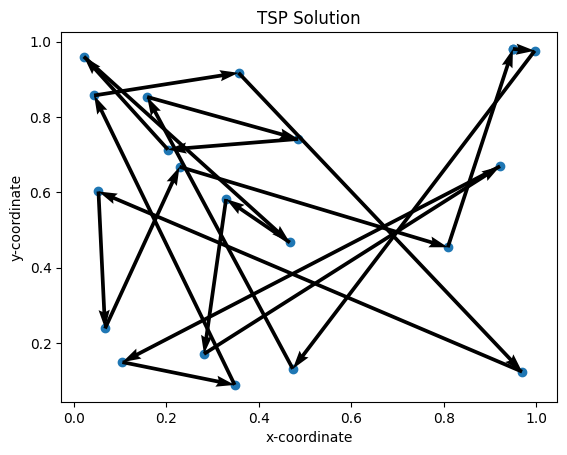

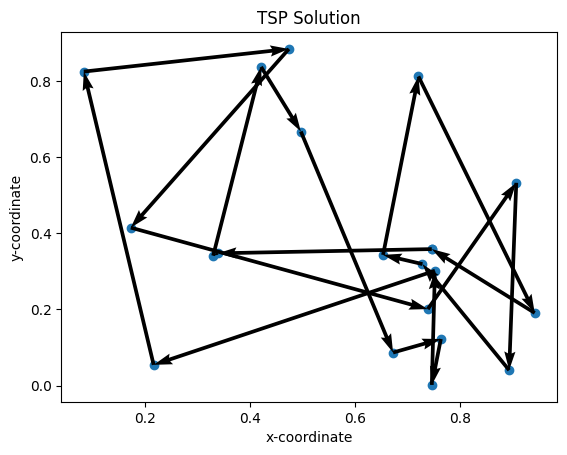

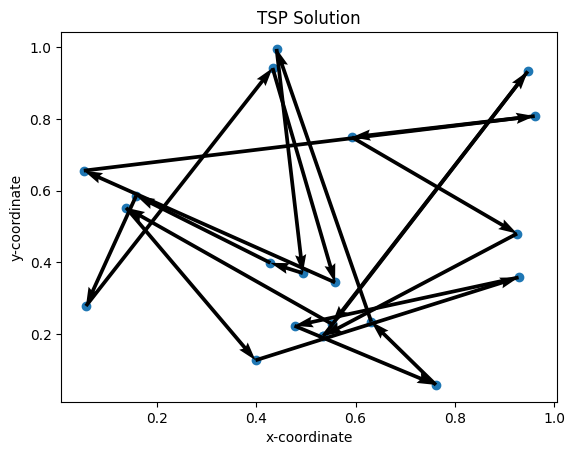

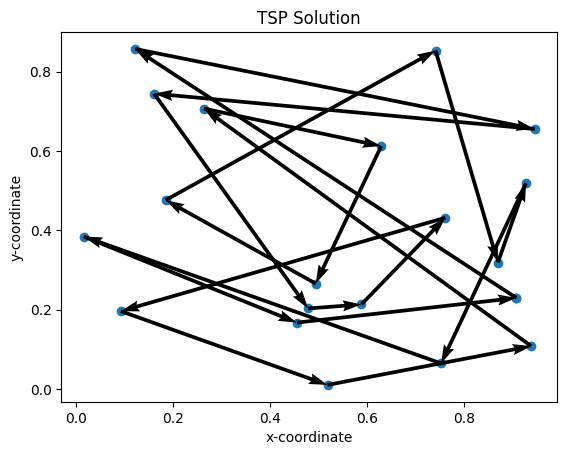

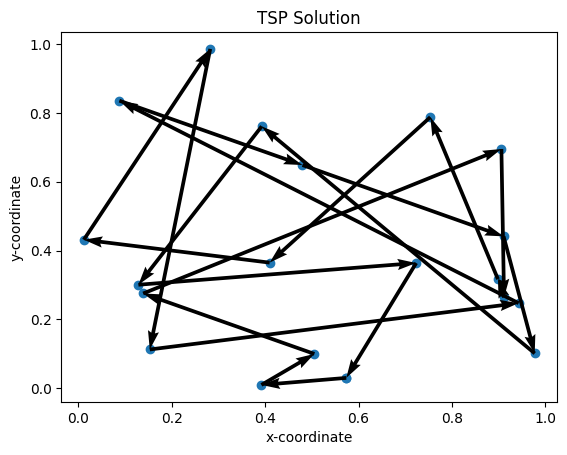

In [4]:
# Plot 
# env.render(td)
# td.set('action', actions)
for i in range(5):
    env.render(td[i])

## Encoder

We use a `GraphAttentionEncoder` that is shared with most models (we just import it from RL4CO)

## Decoder

The decoder is takes initial embeddings and rolls out over the environment until all environments are done

In [5]:
@dataclass
class PrecomputedCache:
    node_embeddings: torch.Tensor
    graph_context: torch.Tensor
    glimpse_key: torch.Tensor
    glimpse_val: torch.Tensor
    logit_key: torch.Tensor


class Decoder(nn.Module):
    def __init__(self, env, embedding_dim, num_heads, **logit_attn_kwargs):
        super(Decoder, self).__init__()

        self.env = env
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        assert embedding_dim % num_heads == 0

        self.context = env_context(self.env.name, {"embedding_dim": embedding_dim})
        self.dynamic_embedding = env_dynamic_embedding(
            self.env.name, {"embedding_dim": embedding_dim}
        )

        # For each node we compute (glimpse key, glimpse value, logit key) so 3 * embedding_dim
        self.project_node_embeddings = nn.Linear(
            embedding_dim, 3 * embedding_dim, bias=False
        )
        self.project_fixed_context = nn.Linear(embedding_dim, embedding_dim, bias=False)

        # MHA
        self.logit_attention = LogitAttention(
            embedding_dim, num_heads, **logit_attn_kwargs
        )

    def forward(self, td, embeddings, decode_type="sampling", softmax_temp=None):
        outputs = []
        actions = []

        # Compute keys, values for the glimpse and keys for the logits once as they can be reused in every step
        cached_embeds = self._precompute(embeddings)

        while not td["done"].all():
            log_p, mask = self._get_log_p(cached_embeds, td, softmax_temp)

            # Select the indices of the next nodes in the sequences, result (batch_size) long
            action = decode_probs(log_p.exp(), mask, decode_type=decode_type)

            td.set("action", action)
            td = self.env.step(td)["next"]

            # Collect output of step
            outputs.append(log_p)
            actions.append(action)

        outputs, actions = torch.stack(outputs, 1), torch.stack(actions, 1)
        td.set("reward", self.env.get_reward(td, actions))
        return outputs, actions, td

    def _precompute(self, embeddings):
        # The fixed context projection of the graph embedding is calculated only once for efficiency
        graph_embed = embeddings.mean(1)

        # The projection of the node embeddings for the attention is calculated once up front
        (
            glimpse_key_fixed,
            glimpse_val_fixed,
            logit_key_fixed,
        ) = self.project_node_embeddings(embeddings).chunk(3, dim=-1)

        # Organize in a TensorDict for easy access
        cached_embeds = PrecomputedCache(
            node_embeddings=embeddings,
            graph_context=self.project_fixed_context(graph_embed),
            glimpse_key=glimpse_key_fixed,
            glimpse_val=glimpse_val_fixed,
            logit_key=logit_key_fixed,
        )

        return cached_embeds

    def _get_log_p(self, cached, td, softmax_temp):
        step_context = self.context(cached.node_embeddings, td)  # [batch, embed_dim]
        glimpse_q = (cached.graph_context + step_context).unsqueeze(1)  # [batch, 1, embed_dim]

        # Compute keys and values for the nodes
        (
            glimpse_key_dynamic,
            glimpse_val_dynamic,
            logit_key_dynamic,
        ) = self.dynamic_embedding(td)
        glimpse_k = cached.glimpse_key + glimpse_key_dynamic
        glimpse_v = cached.glimpse_val + glimpse_val_dynamic
        logit_k = cached.logit_key + logit_key_dynamic


        # Get the mask
        mask = ~td["action_mask"]
        
        # Compute log prob: MHA + single-head attention
        log_p = self.logit_attention(
            glimpse_q, glimpse_k, glimpse_v, logit_k, mask, softmax_temp
        )

        return log_p, mask

## Policy

In [6]:

class AttentionModelPolicy(nn.Module):
    def __init__(
        self,
        env: EnvBase,
        encoder: nn.Module = None,
        decoder: nn.Module = None,
        embedding_dim: int = 128,
        num_encode_layers: int = 3,
        num_heads: int = 8,
        normalization: str = "batch",
        mask_inner: bool = True,
        force_flash_attn: bool = False,
        train_decode_type: str = "sampling",
        val_decode_type: str = "greedy",
        test_decode_type: str = "greedy",
        **unused_kw
    ):
        super(AttentionModelPolicy, self).__init__()
        if len(unused_kw) > 0: print(f"Unused kwargs: {unused_kw}")

        self.env = env
        self.init_embedding = env_init_embedding(
            self.env.name, {"embedding_dim": embedding_dim}
        )

        self.encoder = (
            GraphAttentionEncoder(
                num_heads=num_heads,
                embed_dim=embedding_dim,
                num_layers=num_encode_layers,
                normalization=normalization,
                force_flash_attn=force_flash_attn,
            )
            if encoder is None
            else encoder
        )

        self.decoder = (
            Decoder(
                env,
                embedding_dim,
                num_heads,
                mask_inner=mask_inner,
                force_flash_attn=force_flash_attn,
            )
            if decoder is None
            else decoder
        )

        self.train_decode_type = train_decode_type
        self.val_decode_type = val_decode_type
        self.test_decode_type = test_decode_type

    def forward(
        self,
        td: TensorDict,
        phase: str = "train",
        return_actions: bool = False,
        **decoder_kwargs,
    ) -> TensorDict:
        # Encode and get embeddings
        embedding = self.init_embedding(td)
        encoded_inputs = self.encoder(embedding)

        # Get decode type depending on phase
        if decoder_kwargs.get("decode_type", None) is None:
            decoder_kwargs["decode_type"] = getattr(self, f"{phase}_decode_type")

        # Decode to get log_p, action and new state
        log_p, actions, td = self.decoder(td, encoded_inputs, **decoder_kwargs)

        # Log likelyhood is calculated within the model since returning it per action does not work well with
        ll = get_log_likelihood(log_p, actions, td.get("mask", None))
        out = {
            "reward": td["reward"],
            "log_likelihood": ll,
            "actions": actions if return_actions else None,
        }
        return out


## Test the Policy only

The policy takes an initial state and gives back collected rewards and log likelihood. We can also return extras such as actions

In [7]:
# Load environment with test data
env = TSPEnv()

dataset = env.dataset(batch_size=[10000])

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=False,  # no need to shuffle, we're resampling every epoch
    num_workers=0,
    collate_fn=TensorDictCollate(),
)

policy = AttentionModelPolicy(
    env,
).to("cuda")

# model = torch.compile(model)

td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = policy(td, decode_type="sampling", return_actions=False)

print(out)

{'reward': tensor([ -8.1023,  -8.0560,  -6.0646,  -7.8802,  -9.2959, -11.1512, -12.0770,
         -8.5009,  -9.9335,  -8.7289, -11.6064, -10.8535,  -8.5311,  -9.4846,
         -9.7712,  -8.2674, -12.1301,  -8.8236, -11.8870, -10.2550,  -9.8934,
         -8.1046,  -9.5637,  -9.2473,  -8.3758, -10.2314,  -6.9297,  -8.9875,
         -8.8708,  -9.7006,  -8.5534, -10.4867, -10.6873,  -8.3345,  -7.1015,
         -8.4035,  -9.6067,  -8.5778, -11.1184, -10.8296,  -6.2385, -10.6467,
         -9.0016,  -7.7790,  -9.2246,  -7.5551, -10.6732,  -8.7293,  -8.4581,
         -9.9576,  -9.6863,  -9.3361, -10.2460, -11.2881, -11.2656, -10.3700,
        -10.2723,  -9.2038,  -8.4176,  -9.8258,  -9.3017,  -8.8901,  -7.5337,
         -8.8172], device='cuda:0'), 'log_likelihood': tensor([-33.2257, -30.6798, -30.0397, -34.2532, -34.6564, -36.3559, -41.9489,
        -37.1139, -35.2243, -35.0093, -38.5292, -34.7272, -32.6584, -41.1722,
        -39.8640, -32.4345, -40.7910, -41.1163, -36.1937, -38.4915, -37.3967

## Create full AM: `env` + `policy` + `baseline`

The full model includes REINFORCE baseline and the policy: it contains the logic for training. 
For example, in REINFORCE with a rollout baseline, a copy of the policy is used as the baseline to calculate the advantages and it is updated only when the new policy is actually better than the baseline.

In [8]:
class AttentionModel(nn.Module):
    def __init__(self, env, policy=None, baseline=None):
        """
        Attention Model for neural combinatorial optimization based on REINFORCE
        Based on Wouter Kool et al. (2018) https://arxiv.org/abs/1803.08475
        Refactored from reference implementation: https://github.com/wouterkool/attention-learn-to-route

        Args:
            env: TorchRL Environment
            policy: Policy
            baseline: REINFORCE Baseline
        """
        super().__init__()
        self.env = env
        self.policy = AttentionModelPolicy(env) if policy is None else policy
        self.baseline = (
            WarmupBaseline(RolloutBaseline()) if baseline is None else baseline
        )

    def forward(self, td: TensorDict, phase: str = "train", **policy_kwargs):
        # Evaluate model, get costs and log probabilities
        out = self.policy(td, phase, **policy_kwargs)

        if phase == "train":
            # Evaluate baseline
            bl_val, bl_loss = self.baseline.eval(td, -out["reward"])

            # Calculate loss
            advantage = -out["reward"] - bl_val
            reinforce_loss = (advantage * out["log_likelihood"]).mean()
            loss = reinforce_loss + bl_loss
            out.update(
                {
                    "loss": loss,
                    "reinforce_loss": reinforce_loss,
                    "bl_loss": bl_loss,
                    "bl_val": bl_val,
                }
            )

        return out

    def setup(self, lit_module):
        # Make baseline taking model itself and train_dataloader from model as input
        self.baseline.setup(
            self.policy,
            lit_module.val_dataloader(),
            self.env,
            device=get_lightning_device(lit_module),
        )

    def on_train_epoch_end(self, lit_module):
        self.baseline.epoch_callback(
            self.policy,
            lit_module.val_dataloader(),
            lit_module.current_epoch,
            self.env,
            device=get_lightning_device(lit_module),
        )

In [9]:
baseline = WarmupBaseline(RolloutBaseline())

model = AttentionModel(
    env,
    policy,
    baseline=baseline,
).to("cuda")


td = next(iter(dataloader)).to("cuda")
td = env.reset(td)

out = model(td, decode_type="sampling")

print(out)

{'reward': tensor([ -8.3212,  -7.2047,  -7.6691,  -8.9995,  -8.4292,  -7.9047,  -9.9213,
         -7.3956, -10.1577,  -8.3719,  -7.3779, -10.6138,  -7.9357,  -9.4588,
         -9.8346,  -7.9540, -10.5932, -10.5531,  -9.3896,  -9.2238, -10.6166,
         -9.0390,  -9.4468,  -8.7641,  -9.4112,  -8.6628, -11.2701,  -8.9262,
         -9.7133,  -9.5533,  -7.8588, -10.6528, -10.7772,  -8.4507,  -7.5549,
         -9.7733,  -9.5850,  -8.5189,  -9.8919, -11.1273,  -7.1225,  -8.8150,
         -9.3653, -10.4021, -11.3527,  -8.2380,  -7.8491,  -9.9989, -10.2382,
        -10.0839,  -9.1933,  -9.4774, -10.7335, -10.5593,  -9.1308,  -8.8841,
        -10.8594,  -8.3264, -11.1640, -11.3131, -10.3718, -11.3333,  -9.1198,
         -9.2038], device='cuda:0'), 'log_likelihood': tensor([-41.8708, -28.1370, -34.1805, -33.5317, -37.0294, -35.1928, -36.4459,
        -35.4155, -35.2620, -36.3926, -34.2614, -43.2065, -35.2314, -33.4185,
        -40.6712, -33.7917, -34.3625, -44.6497, -40.8433, -38.2407, -43.5810

## Lightning Module

In [10]:
class RL4COLitModule(L.LightningModule):
    def __init__(self, env, model, cfg):
        """
        Base LightningModule for Neural Combinatorial Optimization
        If model_cfg is passed, it will take precedence over cfg.model
        Likewise for env_cfg
        
        NOTE: simplified not to use Hydra instantiate here
        """

        super().__init__()
        # this line ensures params passed to LightningModule will be saved to ckpt
        # it also allows to access params with 'self.hparams' attribute
        self.save_hyperparameters(cfg)
        self.cfg = cfg
        self.env = env
        self.model = model
        self.instantiate_metrics()

    def instantiate_metrics(self):
        """Dictionary of metrics to be logged at each phase"""
        self.train_metrics = self.cfg.metrics.get("train", ["loss", "reward"])
        self.val_metrics = self.cfg.metrics.get("val", ["reward"])
        self.test_metrics = self.cfg.metrics.get("test", ["reward"])
        self.log_on_step = self.cfg.metrics.get("log_on_step", True)


    def setup(self, stage="fit"):
        self.train_dataset = self.env.dataset(self.cfg.data.train_size, "train")
        self.val_dataset = self.env.dataset(self.cfg.data.val_size, "val")
        test_size = self.cfg.data.get("test_size", self.cfg.data.val_size)
        self.test_dataset = self.env.dataset(test_size, "test")
        if hasattr(self.model, "setup"):
            self.model.setup(self)

    def configure_optimizers(self):
        parameters = (
            self.parameters()
        )  # this will train task specific parameters such as Retrieval head for AAN
        optimizer = torch.optim.Adam(
            parameters, lr=self.cfg.optim.lr, weight_decay=self.cfg.optim.weight_decay
        )
        return [optimizer] # NOTE: for simplicity we do not include the scheduler here
    
    def shared_step(self, batch: Any, batch_idx: int, phase: str):
        td = self.env.reset(batch)
        out = self.model(td, phase)
        # Log metrics
        metrics = getattr(self, f"{phase}_metrics")
        metrics = {f"{phase}/{k}": v.mean() for k, v in out.items() if k in metrics}
        self.log_dict(
            metrics,
            on_step=self.log_on_step,
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
        )

        return {"loss": out.get("loss", None)}

    def training_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="train")

    def validation_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="val")

    def test_step(self, batch: Any, batch_idx: int):
        return self.shared_step(batch, batch_idx, phase="test")

    def train_dataloader(self):
        return self._dataloader(self.train_dataset)

    def val_dataloader(self):
        return self._dataloader(self.val_dataset)
    
    def test_dataloader(self):
        return self._dataloader(self.test_dataset)

    def on_train_epoch_end(self):
        if hasattr(self.model, "on_train_epoch_end"):
            self.model.on_train_epoch_end(self)
        self.train_dataset = self.env.dataset(self.cfg.data.train_size, "train")

    def _dataloader(self, dataset):
        return DataLoader(
            dataset,
            batch_size=self.cfg.data.batch_size,
            shuffle=False,  # no need to shuffle, we're resampling every epoch
            num_workers=self.cfg.data.get("num_workers", 0),
            collate_fn=TensorDictCollate(),
        )


## Main training setup

In [11]:
config = DictConfig(
    {
        "data": {
            "train_size": 100000, # with 1 epochs, this is 1k samples
            "val_size": 10000, 
            "batch_size": 512,
        },
        "optim": {
            "lr": 1e-4,
            "weight_decay": 1e-5,
        },
        "metrics": {
            "train": ["loss", "reward"],
            "val": ["reward"],
            "test": ["reward"],
            "log_on_step": True,
        },
        
    }
)


lit_module = RL4COLitModule(env, model, config)

## Fit model

In [12]:
# Trick to make calculations faster
torch.set_float32_matmul_precision("medium")

# Trainer
trainer = L.Trainer(
    max_epochs=1, # 10
    accelerator="gpu",
    logger=None, # can replace with WandbLogger, TensorBoardLogger, etc.
    precision="16-mixed", # Lightning will handle casting to float16
    log_every_n_steps=1,   
    gradient_clip_val=1.0, # clip gradients to avoid exploding gradients!
)

# Fit the model
trainer.fit(lit_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type           | Params
-----------------------------------------
0 | env   | TSPEnv         | 0     
1 | model | AttentionModel | 1.4 M 
-----------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.681     Total estimated model params size (MB)
2023-05-16 02:18:30.043992: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-16 02:18:30.071972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruc

/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 196/196 [00:06<00:00, 31.89it/s, v_num=13, train/reward_step=-4.25, train/loss_step=-.439, val/reward_step=-4.05, val/reward_epoch=-4.09, train/reward_epoch=-4.78, train/loss_epoch=1.430]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 196/196 [00:06<00:00, 28.14it/s, v_num=13, train/reward_step=-4.25, train/loss_step=-.439, val/reward_step=-4.05, val/reward_epoch=-4.09, train/reward_epoch=-4.78, train/loss_epoch=1.430]


In [13]:
trainer.test(lit_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/botu/Dev/rl4co/env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 71.28it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│     test/reward_epoch     │    -4.0783185958862305    │
└───────────────────────────┴───────────────────────────┘

[{'test/reward_epoch': -4.0783185958862305}]

## Analyze results

In [14]:
lit_module.cfg.data.batch_size = 100 # so we load the whole test set
dl = lit_module.test_dataloader()
policy = lit_module.model.policy.to("cuda")

batch = next(iter(dl))
td = env.reset(batch).to("cuda")
out = policy(td, decode_type="greedy", return_actions=True)
out['reward'].mean()

tensor(-4.1433, device='cuda:0')

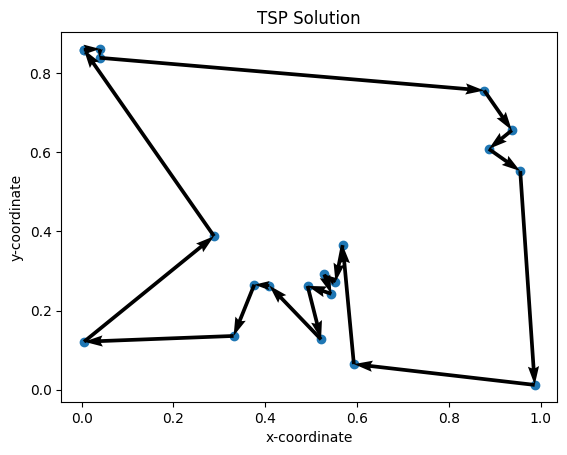

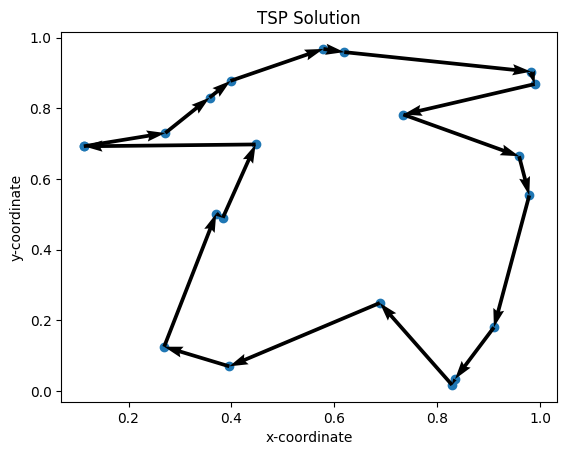

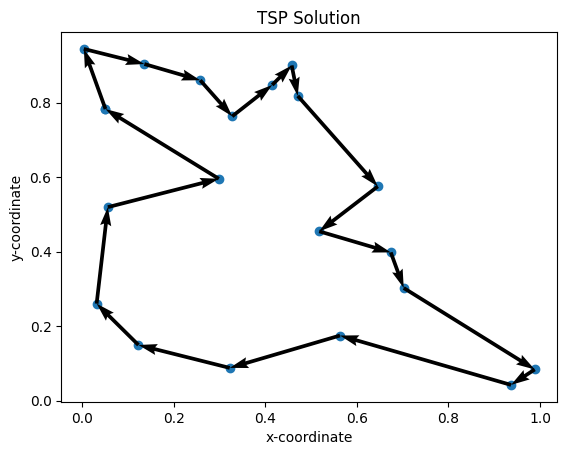

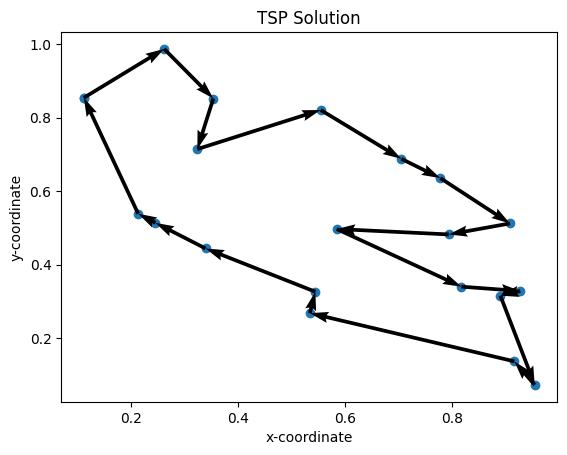

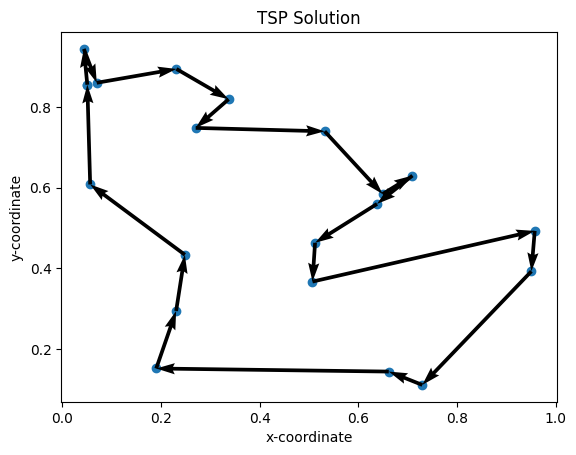

In [15]:
td.set('reward', out['reward'])
td.set('action', out['actions'])
for i in range(5):
    env.render(td[i])